# Import libraries

In [4]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


# Data preprocessing

In [5]:
def fetch_historical_data(symbol, interval, limit=1000):
    url = f'https://api.binance.com/api/v3/klines?symbol={symbol}&interval={interval}&limit={limit}'
    response = requests.get(url)
    data = response.json()
    df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    df = df[['open', 'high', 'low', 'close', 'volume']].astype(float)
    return df

# Fetch data for different intervals
df_1m = fetch_historical_data('BTCUSDT', '1m')
df_1h = fetch_historical_data('BTCUSDT', '1h')
df_4h = fetch_historical_data('BTCUSDT', '4h')
df_1d = fetch_historical_data('BTCUSDT', '1d')

# Prepare the training data
def prepare_data(data):
    data['returns'] = data['close'].pct_change()
    data.dropna(inplace=True)
    return data

df_1m = prepare_data(df_1m)
df_1h = prepare_data(df_1h)
df_4h = prepare_data(df_4h)
df_1d = prepare_data(df_1d)

# Modeling

In [6]:
from catboost import Pool, CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
frequency = '1d'

In [ ]:
data = fetch_historical_data('BTCUSDT', '1d')
data.head()

,open,high,low,close,volume
timestamp,,,,,
2021-10-26,63078.78,63293.48,59817.55,60328.81,40217.50083
2021-10-27,60328.81,61496.00,58000.00,58413.44,62124.49016
2021-10-28,58413.44,62499.00,57820.00,60575.89,61056.35301
2021-10-29,60575.90,62980.00,60174.81,62253.71,43973.90414
2021-10-30,62253.70,62359.25,60673.00,61859.19,31478.12566


In [ ]:
def prepare_data(data):
    data['returns'] = data['close'].pct_change()
    data.dropna(inplace=True)
    return data

In [ ]:
data = prepare_data(data)

In [ ]:
data = data['returns']
train_data = data.iloc[:int(len(data)*0.8)]
test_data = data.iloc[int(len(data)*0.8):]
train_label = train_data.shift(-1)
train_label.iloc[-1] = test_data.iloc[-1]

train_pool = Pool(train_data, train_label)
test_pool = Pool(test_data)

/opt/anaconda3/envs/CSS483/lib/python3.12/site-packages/catboost/core.py:941: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(data[0], Iterable):


In [ ]:
model = CatBoostRegressor()
model.fit(train_pool)

Learning rate set to 0.039517
0:	learn: 0.0291451	total: 56.5ms	remaining: 56.4s
1:	learn: 0.0291327	total: 56.9ms	remaining: 28.4s
2:	learn: 0.0291233	total: 57.3ms	remaining: 19s
3:	learn: 0.0291158	total: 57.7ms	remaining: 14.4s
4:	learn: 0.0291074	total: 58.1ms	remaining: 11.6s
5:	learn: 0.0291020	total: 58.4ms	remaining: 9.68s
6:	learn: 0.0290875	total: 58.8ms	remaining: 8.34s
7:	learn: 0.0290711	total: 59.1ms	remaining: 7.33s
8:	learn: 0.0290544	total: 59.4ms	remaining: 6.54s
9:	learn: 0.0290413	total: 59.8ms	remaining: 5.92s
10:	learn: 0.0290315	total: 60.1ms	remaining: 5.41s
11:	learn: 0.0290224	total: 60.5ms	remaining: 4.98s
12:	learn: 0.0290141	total: 60.9ms	remaining: 4.62s
13:	learn: 0.0290061	total: 61.2ms	remaining: 4.31s
14:	learn: 0.0289985	total: 61.5ms	remaining: 4.04s
15:	learn: 0.0289886	total: 61.9ms	remaining: 3.81s
16:	learn: 0.0289777	total: 62.2ms	remaining: 3.6s
17:	learn: 0.0289688	total: 62.5ms	remaining: 3.41s
18:	learn: 0.0289575	total: 62.9ms	remaining: 3

In [ ]:
train_preds = model.predict(train_pool)
test_preds = model.predict(test_pool)

In [ ]:
print(f'R2: {r2_score(train_data, train_preds):.4f}')
print(f'MSE: {mean_squared_error(train_data, train_preds):.4f}')

R2: -0.1407
MSE: 0.0010


In [ ]:
print(f'R2: {r2_score(test_data, test_preds):.4f}')
print(f'MSE: {mean_squared_error(test_data, test_preds):.4f}')

R2: -0.1040
MSE: 0.0009


In [ ]:
def plot_forecast_result(train_pred, test_pred, actual, title):
  plt.title(title)
  plt.plot(actual)
  plt.plot(actual.iloc[:len(train_pred)].index, train_pred)
  plt.plot(actual.iloc[len(train_pred):].index, test_pred, color='red')
  plt.xlabel('Date')
  model = title.split()[0]
  plt.legend([f'Actual', f'{model} (Train)', f'{model} (Test)'])
  plt.show()

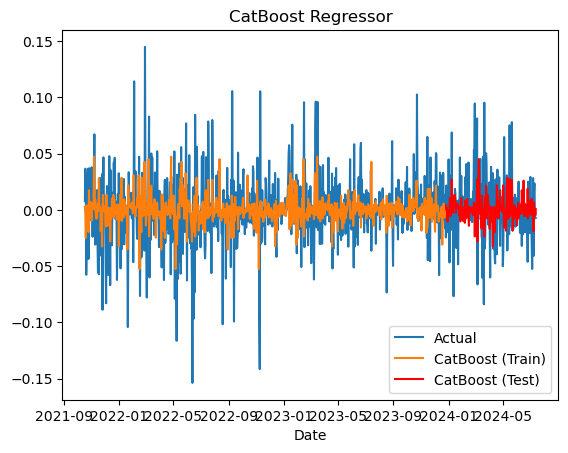

In [ ]:
plot_forecast_result(train_preds, test_preds, data, 'CatBoost Regressor')

# Using Trading Agent

In [ ]:
import sys
sys.path.append('..')

In [ ]:
from ExampleAgent import ExampleAgent

In [ ]:
# Backtesting function
def backtest(agent, data):
    agent.train_model(data)
    for timestamp, row in data.iterrows():
        agent.trade(data.loc[:timestamp])
    return agent.get_portfolio_value(row['close'])

# Initialize agents
agent_1m = ExampleAgent('CatBoost Agent 1m')
agent_1h = ExampleAgent('CatBoost Agent 1h')
agent_4h = ExampleAgent('CatBoost Agent 4h')
agent_1d = ExampleAgent('CatBoost Agent 1d')

# Backtest each agent
portfolio_value_1m = backtest(agent_1m, df_1m)
portfolio_value_1h = backtest(agent_1h, df_1h)
portfolio_value_4h = backtest(agent_4h, df_4h)
portfolio_value_1d = backtest(agent_1d, df_1d)
print(f"Portfolio Value for 1m Interval: {portfolio_value_1m}")
print(f"Portfolio Value for 1h Interval: {portfolio_value_1h}")
print(f"Portfolio Value for 4h Interval: {portfolio_value_4h}")
print(f"Portfolio Value for 1d Interval: {portfolio_value_1d}")

/opt/anaconda3/envs/CSS483/lib/python3.12/site-packages/catboost/core.py:941: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(data[0], Iterable):


2024-07-12 10:49:35.669773: CatBoost Agent 1m - Buy at 58488.01
2024-07-12 10:49:35.670331: CatBoost Agent 1m - Hold
2024-07-12 10:49:35.670743: CatBoost Agent 1m - Sell at 58498.83
2024-07-12 10:49:35.671139: CatBoost Agent 1m - Hold
2024-07-12 10:49:35.671536: CatBoost Agent 1m - Buy at 58476.01
2024-07-12 10:49:35.671928: CatBoost Agent 1m - Sell at 58487.15
2024-07-12 10:49:35.672303: CatBoost Agent 1m - Hold
2024-07-12 10:49:35.672670: CatBoost Agent 1m - Hold
2024-07-12 10:49:35.673041: CatBoost Agent 1m - Buy at 58484.01
2024-07-12 10:49:35.673408: CatBoost Agent 1m - Sell at 58483.95
2024-07-12 10:49:35.673792: CatBoost Agent 1m - Hold
2024-07-12 10:49:35.674152: CatBoost Agent 1m - Buy at 58482.62
2024-07-12 10:49:35.674514: CatBoost Agent 1m - Hold
2024-07-12 10:49:35.674870: CatBoost Agent 1m - Hold
2024-07-12 10:49:35.675229: CatBoost Agent 1m - Sell at 58443.99
2024-07-12 10:49:35.675590: CatBoost Agent 1m - Buy at 58415.25
2024-07-12 10:49:35.675951: CatBoost Agent 1m - H